In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
class Config(object):
    raw_data_path = 'poetryFromTang.txt'
    numpy_data_path = 'data.npz'
    
    batch_size = 32
    embedding_dim = 100
    hidden_dim = 100
    
    model_path = 'model.pkl'
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    learning_rate = 0.001
    epochs = 50
    
    max_generate_length = 50
        
arg = Config()


## 数据处理

In [3]:
def read_data(path):
    with open(path) as f:
        poetry = []
        sentence = ''
        for line in f.readlines():
            line = line.strip()
            if line ==  '':
                poetry.append(sentence)
                sentence = ''
            else:
                sentence += line
    return poetry


def pad_sequence(sequences, max_len=None, dtype='int32', padding='post', truncating='post', value=0):
    '''
    填充语句
    将长度小于max_len的句子用空格补充，使其长度为max_len
    将长度大于max_len的句子进行截断，使其长度为max_len
    :param sequences: list 不同句子
    :param max_len: 每句的最大长度
    :param dtype: 返回句子的数据类型
    :param padding: 'pre'或 'post', pre：在句子前面补充空格， post：在句子后面补充
    :param truncating: 'pre'或'post', pre：截断并舍弃长句子的前面超出长度的部分，post:截断后面部分
    :param value: 用于补充的值
    :return: X numpy 矩阵 size = ( number_of_sequence x max_len )
    '''
    print('padding data...')
    length = []
    for s in sequences:
        length.append(len(s))

    if max_len is None:
        max_len = max(length)

    x = (np.ones((len(sequences), max_len))*value).astype(dtype)
    for index, s in enumerate(sequences):
        if not length[index] or length[index] == max_len:
            continue
        if length[index] > max_len:
            if truncating == 'pre':
                x[index, -max_len:] = s[-max_len:]
            elif truncating == 'post':
                x[index, :max_len] = s[:max_len]
            else:
                raise ValueError('truncating error -  %s' % truncating)

        elif length[index] < max_len:
            if padding == 'pre':
                x[index, -length[index]:] = s
            elif padding == 'post':
                x[index, :length[index]] = s
            else:
                raise ValueError('padding error - %s' % padding)
    return x


def get_data():
    # 读取数据
    print('getting data...')
    poetry = read_data(arg.raw_data_path)
    
    # 建立char和index的mapping
    chars = {c for sentence in poetry for c in sentence}
    char2index = {char: index for index, char in enumerate(chars)}
    char2index['<START>'] = len(char2index)
    char2index['<EOP>'] = len(char2index)
    char2index['<SPACE>'] = len(char2index)
    index2char = {index: char for char, index in list(char2index.items())}
    
    # 为每首诗加上起始和终止符 
    for i in range(len(poetry)):
        poetry[i] = ['<START>'] + list(poetry[i]) + ['<EOP>']
    
    # 将汉字转变为数字  
    poetry = [[char2index[char] for char in sentence] for sentence in poetry]
    
    # 进行padding 
    padding_data = pad_sequence(poetry, max_len=100, 
                                padding='post', truncating='post',
                                value=char2index['<SPACE>'])
    

    return padding_data, char2index, index2char



## 建立模型

In [4]:
class PoetryModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(PoetryModel,self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.num_layers = 2
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=self.num_layers)
        self.linear = nn.Linear(self.hidden_dim, vocab_size)
        
    def forward(self, x, hidden=None):
        sequence_length, batch_size = x.size()
        if hidden is None:
            h_0 = x.data.new(self.num_layers, batch_size, self.hidden_dim).fill_(0).float()
            c_0 = x.data.new(self.num_layers, batch_size, self.hidden_dim).fill_(0).float()
        else:
            h_0, c_0 = hidden
            
        # embeds shape （sequence, batch_size, embedding_dim)
        embeds = self.embedding(x)
        
        # output shape (sequence, batch_size, hidden_dim)
        output, hidden = self.lstm(embeds, (h_0, c_0))
        
        # output shape (sequence*batch_size, vocab_size)
        output = self.linear(output.view(sequence_length*batch_size, -1))
        
        return output, hidden
    


## 训练

In [5]:
data, char2index, index2char = get_data()
data = torch.from_numpy(data)
data_loader = torch.utils.data.DataLoader(data, batch_size=arg.batch_size, shuffle=True)

model = PoetryModel(len(char2index), arg.embedding_dim, arg.hidden_dim)
if os.path.exists(arg.model_path):
    model.load_state_dict(torch.load(arg.model_path))
model.to(arg.device)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

print('training...')
epoch_loss = []
for epoch in range(arg.epochs):
    iter_loss = []
    for index, data in enumerate(data_loader):
        # 转置成shape ( sequence_length, batch_size )  sequence_length 为max_len
        # contiguous 为了改变底层的存储，contiguous重新按顺序存储，否则执行view会报错
        data = data.long().transpose(1, 0).contiguous().to(arg.device)

        x, y = data[:-1, :], data[1:, :]
        y_, _ = model(x)

        optimizer.zero_grad()
        loss = criterion(y_, y.view(-1))
        loss.backward()
        optimizer.step()

        iter_loss.append(loss.item())
    epoch_loss.append(sum(iter_loss)/len(iter_loss))

    print('Epoch %d, loss %.4f' % (epoch, epoch_loss[-1]))
torch.save(model.state_dict(), arg.model_path)

    

getting data...
padding data...
training...
Epoch 0, loss 7.6840
Epoch 1, loss 6.9151
Epoch 2, loss 6.1275
Epoch 3, loss 5.1883
Epoch 4, loss 4.6228
Epoch 5, loss 4.7455
Epoch 6, loss 4.3252
Epoch 7, loss 4.3018
Epoch 8, loss 4.0782
Epoch 9, loss 4.3203
Epoch 10, loss 4.0875
Epoch 11, loss 4.0975
Epoch 12, loss 4.2681
Epoch 13, loss 3.9342
Epoch 14, loss 4.0623
Epoch 15, loss 4.1967
Epoch 16, loss 4.2694
Epoch 17, loss 4.0806
Epoch 18, loss 4.0705
Epoch 19, loss 3.9069
Epoch 20, loss 3.8527
Epoch 21, loss 3.9969
Epoch 22, loss 3.9416
Epoch 23, loss 3.7981
Epoch 24, loss 4.2280
Epoch 25, loss 3.8834
Epoch 26, loss 4.3091
Epoch 27, loss 3.8503
Epoch 28, loss 3.9085
Epoch 29, loss 3.7768
Epoch 30, loss 4.0377
Epoch 31, loss 4.1548
Epoch 32, loss 3.8894
Epoch 33, loss 3.9075
Epoch 34, loss 3.9830
Epoch 35, loss 3.8298
Epoch 36, loss 3.6706
Epoch 37, loss 3.8118
Epoch 38, loss 3.6250
Epoch 39, loss 3.7096
Epoch 40, loss 3.7650
Epoch 41, loss 3.5898
Epoch 42, loss 3.6960
Epoch 43, loss 3.598

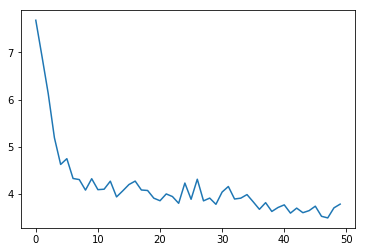

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(epoch_loss)

## 测试 
文本生成

In [8]:
def generate(model, start_chars, char2index, index2char):
    result = list(start_chars)
    start_words_length = len(start_chars)
    input = torch.LongTensor([char2index['<START>']]).view(1,1)
    input = input.to(arg.device)

    hidden = None
    
    for i in range(arg.max_generate_length):
        output, hidden = model(input, hidden)
        if i < start_words_length:
            char = result[i]
            try:
                input = input.data.new([char2index[char]]).view(1, 1)            
            except:
                return '语料库中没有 “%s” 字' % char
        else:
            top_index = output.data[0].topk(1)[1][0].item()
            char = index2char[top_index]
            result.append(char)
            input = input.data.new([top_index]).view(1, 1)
        if char == '<EOP>':
            del result[-1]
            break
            
    return ''.join(result)

In [9]:
start_chars = '君不见黄河之水天上来'
print(generate(model, start_chars, char2index, index2char))

君不见黄河之水天上来，，不不不不。人不不，不以。以以，可以。以以，可定。以以，可以。以以，可定。以以


看样子现在的参数或模型效果不理想,也可能是数据量少